# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('lato_style.mplstyle')

import pandas as pd
from IPython.display import Image

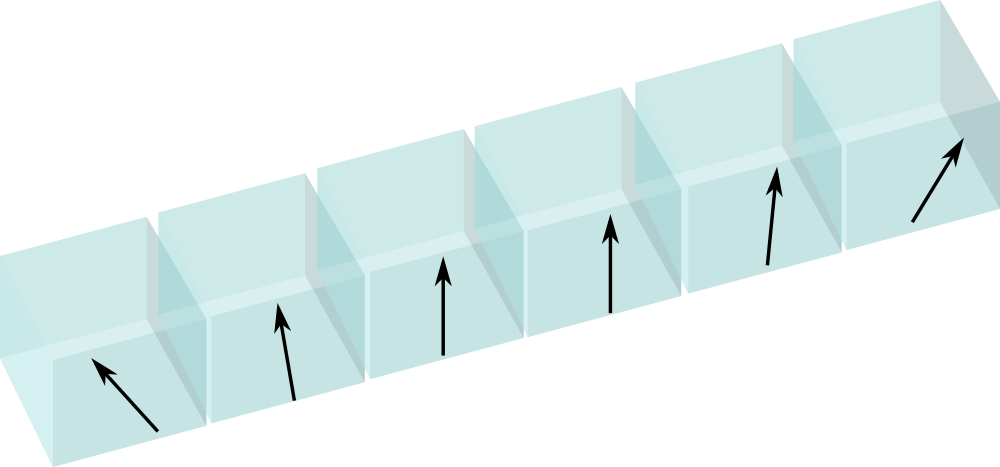

In [2]:
Image('mayavi/one-dim.png')

# 1D Problem

One dimensional standard problem for the *Proposal for a micromagnetic standard problem for materials with Dzyaloshinskii-Moriya interaction* paper.

System:


    * A permalloy-like 1D wire of 100 nm x 5 nm x 5 nm (x,y,z)
    * Interactions: Exchange:                      13  pJ m**-1
                    DMI:                            3  mJ m**-2
                    Uniaxial Anisotropy along z:  0.4  MJ m**-3
                    Ms:                          0.86  A / m  

We will solve and simulate the system using interfacial ($C_{nv}$), bulk ($T$) and $D_{2d}$ DMI 

In [3]:
# System parameters
nm = 1e-9
L = 100 * nm      # sample length in nm
l = L / nm        # scale in nm

# Permalloy-like material (for testing purposes)
A = 13e-12
D = 3e-3
Ku = 0.4e6
Ms = 0.86e6

In [4]:
# Exchange and helical lengths:
mu0 = 4 * np.pi * 1e-7
lex = np.sqrt(2 * A / (mu0 * Ms ** 2))
lD = 4 * np.pi * A / D
print('L_ex =', lex * 1e9, 'nm')
print('L_D =', lD * 1e9, 'nm')

L_ex = 5.289118420310732 nm
L_D = 54.454272662223076 nm


# JOOMMF Simulation

In [5]:
%%capture
import oommfc as oc
import discretisedfield as df
# Reload matplotlib config after loading JOOMMF
plt.style.use('lato_style.mplstyle')

In OOMMF we use custom modules for the calculation of the DMI, which are implemented in the JOOMMF code:

In [6]:
# Set the mesh and initialise the system
mesh = oc.Mesh(p1=(-L/2, 0, 0), p2=(L/2, 1 * nm, 1 * nm), 
               cell=(1 * nm, 1 * nm, 1 * nm))

# In this list we save a simulation for: [Cnv, T, D2d] DMI
systems = [None, None, None]

DMS = [D, D, D]
dmi_list = ['interfacial', 'bulk', 'D2d']
for i, dmi in enumerate(dmi_list):

    systems[i] = oc.System(name=dmi)
    # Add interactions
    systems[i].hamiltonian = oc.Exchange(A=A) + oc.DMI(D=DMS[i], kind=dmi) + \
                             oc.UniaxialAnisotropy(K1=Ku, u=(0, 0, 1))  # + oc.Demag()

Set the magnetisation and the initial state of the system for every simulation:

In [7]:
m_init = (0.1, 0, 1)

for i in range(3):
    systems[i].m = df.Field(mesh, value=m_init, norm=Ms)

Minimise the systems:

In [8]:
md = oc.MinDriver()

for i in range(3):
    md.drive(systems[i])

# systems[0].m.plot_plane('y')
# systems[1].m.plot_plane('z')
# systems[2].m.plot_plane('z')

2018/3/15 15:39: Calling OOMMF (interfacial/interfacial.mif) ... [1.0s]
2018/3/15 15:39: Calling OOMMF (bulk/bulk.mif) ... [0.5s]
2018/3/15 15:39: Calling OOMMF (D2d/D2d.mif) ... [0.4s]


Now we save the data into corresponding variables and plot some of them to check the magnetisation profile:

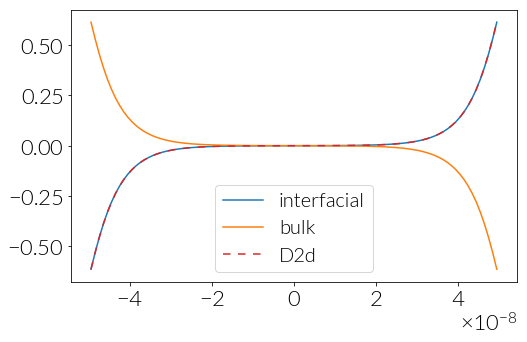

In [9]:
# extract magnetization data
nx, ny, nz = mesh.n

# -----------------------------------------------------------------------------

coordinates = np.array(list(systems[0].m.mesh.coordinates))
x_oommf, y_oommf, z_oommf = coordinates[:, 0], coordinates[:, 1], coordinates[:, 2]


m_oommf = [[None for i in range(3)] for j in range(3)]
for i in range(3):

    m_oommf[i][0], m_oommf[i][1], m_oommf[i][2] = (systems[i].m.x.array.flatten(), 
                                                   systems[i].m.y.array.flatten(),
                                                   systems[i].m.z.array.flatten()
                                                   )
    
    for j in range(3):
        m_oommf[i][j] = np.array(m_oommf[i][j]) / Ms
        
# -----------------------------------------------------------------------------
plt.plot(x_oommf, m_oommf[0][0], label='interfacial')
plt.plot(x_oommf, m_oommf[1][1], label='bulk')
plt.plot(x_oommf, m_oommf[2][1], dashes=(5, 5), label='D2d', color='C3')

plt.legend()

We can show the spin field of the systems by plotting the corresponding components. The relaxed states have canted spins at the extrema of the wire. For the bulk and $D_{2d}$ DMI cases we plot the system in the $yx$ plane:

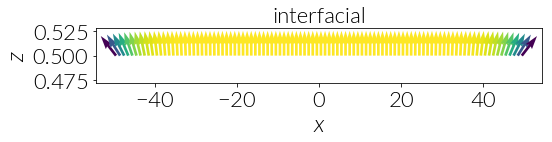

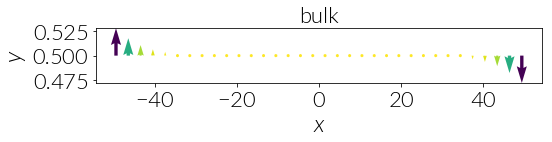

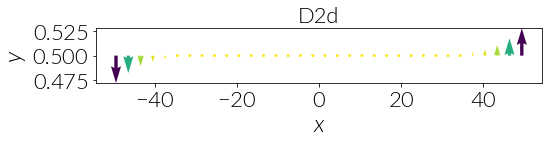

In [10]:
# Plot the components
plt.figure(figsize=(8, 1))
plt.quiver(coordinates[:, 0] * 1e9, coordinates[:, 1] * 1e9, 
           m_oommf[0][0], m_oommf[0][2], m_oommf[0][2])
plt.ylabel(r'$z$')
plt.xlabel(r'$x$')
plt.title(dmi_list[0])

for i in range(1, 3):
    plt.figure(figsize=(8, 1))
    plt.quiver(coordinates[:, 0][::3] * 1e9, coordinates[:, 2][::3] * 1e9, 
               m_oommf[i][0][::3], m_oommf[i][1][::3], m_oommf[i][2][::3], scale=10)
    plt.ylabel(r'$y$')
    plt.xlabel(r'$x$')
    plt.title(dmi_list[i])

# FIDIMAG Simulation

In [11]:
import fidimag

We set interfacial, bulk and $D_{2d}$ DMI simulations for Fidimag:

In [12]:
dx, dy, dz = 1, 1, 1
nx, ny, nz = int(l / dx), 1, 1
mesh = fidimag.common.CuboidMesh(dx=dx, dy=dy, dz=dz, nx=nx, ny=ny, nz=nz,
                                 unit_length=1e-9)

sims = [None for i in range(3)]

for i, dmi in enumerate(['interfacial', 'bulk', 'D_2d']):
    sims[i] = fidimag.micro.Sim(mesh, name='fidimag_1D_' + dmi)
    sims[i].Ms = Ms
    sims[i].set_m((-0.1, 0, 0.9))
    sims[i].add(fidimag.micro.UniformExchange(A=A))
    sims[i].add(fidimag.micro.UniaxialAnisotropy(Ku, axis=(0, 0, 1)))
    sims[i].add(fidimag.micro.DMI(D=D, dmi_type=dmi))

Then relax the system and plot the solutions:

In [13]:
%%capture 

for i in range(3):
    sims[i].driver.do_precession = False
    sims[i].driver.alpha = 0.9
    sims[i].relax(stopping_dmdt=0.01)

# -----------------------------------------------------------------------------

r_fidimag = mesh.coordinates

m_fidimag = [[None for i in range(3)] for j in range(3)]

for i in range(3):
    m_fidimag[i][0] = sims[i].spin.reshape(-1, 3)[:, 0]
    m_fidimag[i][1] = sims[i].spin.reshape(-1, 3)[:, 1]
    m_fidimag[i][2] = sims[i].spin.reshape(-1, 3)[:, 2]

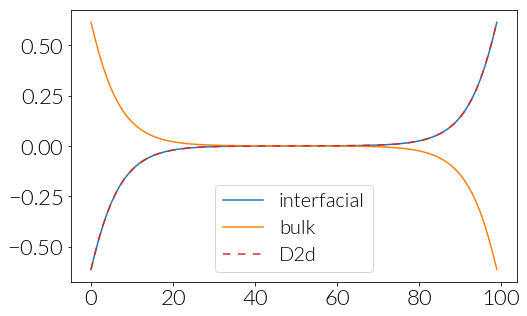

In [14]:
plt.plot(m_fidimag[0][0], label='interfacial')
plt.plot(m_fidimag[1][1], label='bulk')
plt.plot(m_fidimag[2][1], label='D2d', dashes=(5, 5), color='C3')
plt.legend()

# Mumax3

By running the simulations with MuMax3 we can analyse the data. In MuMax3 the DMI is implemented with Neumann boundary conditions, i.e. imposing the condition for the spatial derivative of the magnetisation of spins at the boundary. for a 1D system, the data agrees well when periodicity is imposed in the $y$ direction of the sample. We use these values here:

In [15]:
r_mumax = [None for i in range(3)]
m_mumax = [None for i in range(3)]

for i, dmi in enumerate(['inter', 'bulk', 'D2d']):

    data_mumax = pd.read_csv('../sims/MUMAX3/1D/one_dim_{}_pbc.ovf'.format(dmi), 
                             comment='#', header=None, delim_whitespace=True)
    data_mumax = data_mumax.as_matrix()
    data_mumax[:, :3] *= 1e9
    
    r_mumax[i] = data_mumax[:, :3]
    m_mumax[i] = data_mumax[:, 3:]
    
# data_mumax_Cnv[:, 3:] /= Ms

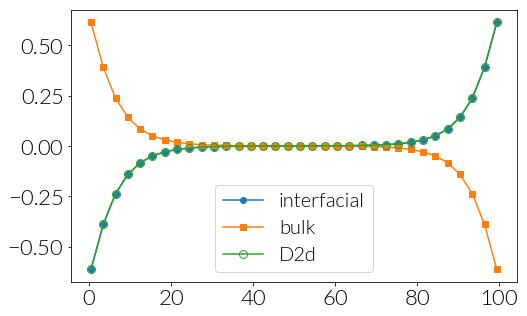

In [16]:
plt.plot(r_mumax[0][:, 0][::3], m_mumax[0][:, 0][::3], 'o-', label='interfacial')
plt.plot(r_mumax[1][:, 0][::3], m_mumax[1][:, 1][::3], 's-', label='bulk')
plt.plot(r_mumax[2][:, 0][::3], m_mumax[2][:, 1][::3], 'o-', markerfacecolor='None', ms=8, label='D2d')
plt.legend()

# ODE Integration

This model has been solved by Rohart and Thiaville in Ref. [1] for interfacial DMI systems. For the interfacial case, the magnetisation only rotates in the $xz$ plane, thus we write

$$\mathbf{m} = (\sin\theta,0,\cos\theta).$$

where $\theta=\theta(x)$. For bulk DMI systems, the magnetisation rotates in the $yz$ plane, hence

$$\mathbf{m} = (0,\sin\theta,\cos\theta).$$

Considering the energy of the magnetic interactions, a variational calculus minimisation on this energy leads to:

$$
\begin{eqnarray}
\frac{\text{d}^2 \theta}{\text{d}x^2} & = & \frac{\sin\theta\cos\theta}{\Delta^2} & \text{for } x(0) <x < x(L) \\
\frac{\text{d}\theta}{\text{d}x} & = & \pm \frac{1}{\xi} & \text{for }x=x(0)\text{ or }x=x(L)
\end{eqnarray}
$$

where $\Delta=\sqrt{2A/K}$, $\xi=2A/D$ and the system has been defined in the $[0, L]$ range. For the boundary condition, the positive sign refers to the interfacial DMI case and the negative sign to the bulk DMI case.

We can solve this system as first order ODEs setting $u=\frac{\text{d}\theta}{\text{d}x}$ and $v=\theta$

Taking the initial value for the derivative, i.e. at $x=0$, we can the condition at $x=0$ and $x=L$ for $\theta$, if we assume that there are no helices within the sample (which means setting an integration constant as 0): 

$$\theta(x=0,L)=\pm\arcsin\left(\frac{\Delta}{\xi}\right)$$

This condition is derived in equation (8) of [1]. Knowing the value of the magnetisation on either extrema, we solve the equation multiple times for different values $\theta'(0)$ of the derivative as initial condition and find the solution that satisfies the condition at $x=L$. We will impose this last condition in the ODE using opposite signs for $\theta$ at $x=0$ and $L$, instead of using the condition from the derivative.

It is important that if we choose the positive or negative sign for $\theta(x=0)$, the solution matches the condition for the derivative, which is positive. For the interfacial DMI case we found out that $\theta(x=0)$ must be negative and positive at $x=L$, and oppositely for the bulk DMI case.

**References**:
[1] S. Rohart and A. Thiaville, PRB **88**, 184422 (2013)

In [17]:
import scipy.integrate

In [18]:
# Use units in the nm scale
delta = (np.sqrt(A / Ku)) / nm
xi = (2 * A / D) / nm

# Set of differential equations for (u, v)
def ode_1d(theta, r, delta=1):
    return np.array([theta[1], 
                      np.cos(theta[0]) * np.sin(theta[0]) / delta ** 2
                      ])


# Define a function to solve the differential equation in the (0, l) range
# for any v(0) condition, u(0) is set to 1/xi
# The function returns the difference with respect to the desired solution at x=l
# The boundary conditions differ in sign for the interfacial and DMI cases
r_array = np.linspace(0, l, 100)

def solve_ode(a, sign=1):  
    # Impose the condition over the angle rather than its derivative
    solution, info = scipy.integrate.odeint(lambda t, r: ode_1d(t, r, delta=delta), 
                                            [np.arcsin(sign * delta / xi), a], r_array, full_output=True)
    # By inspection we found that the right extrema must be positive to match
    # the condition for the derivative
    return solution[:, 0][-1] - np.arcsin(-sign * delta / xi)

We show here the difference $\delta\theta=\theta(L)-\arcsin(\pm\Delta/\xi)$, where the sign depends on the DMI type

/home/david/anaconda3/lib/python3.5/site-packages/matplotlib/mathtext.py:838: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


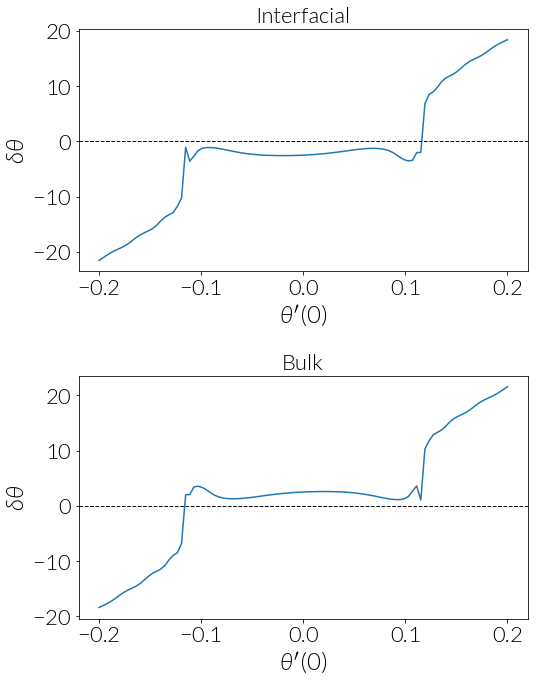

In [19]:
f = plt.figure(figsize=(8, 16/1.6))

aa = np.linspace(-.2, .2, 100)
guesses = [solve_ode(a, sign=-1) for a in aa]
ax = f.add_subplot(211)
plt.plot(aa, guesses)
plt.axhline(y=0, ls='--', lw=1, color='k')
plt.ylabel(r'$\delta\theta$')
plt.xlabel(r"$\theta'(0)$")
plt.title('Interfacial', fontweight='light')

aa = np.linspace(-.2, .2, 100)
guesses = [solve_ode(a, sign=1) for a in aa]
ax = f.add_subplot(212)
plt.plot(aa, guesses)
plt.axhline(y=0, ls='--', lw=1, color='k')
plt.ylabel(r'$\delta\theta$')
plt.xlabel(r"$\theta'(0)$")
plt.title('Bulk', fontweight='light')

plt.tight_layout()

We need the root of this difference, i.e. $\delta\theta=0$ which satisfies the ODE with the desired conditions, thus we use Scipy's `brentq` root-finder. We must notice that there can exist multiple zeros which might indicate different solutions. If we plot them we find that these are multiple cycloidal states. The solution we are interested in is a uniform state with spin canting at the extrema of the sample and it is obtained from the negative root:

In [20]:
# Find the root from the differences:
guess_int = scipy.optimize.brentq(lambda a: solve_ode(a, sign=-1), 0., 0.2)
guess_bulk = scipy.optimize.brentq(lambda a: solve_ode(a, sign=1), -0.2, 0.)

print('Interfacial: ', guess_int)
print('Bulk: ', guess_bulk)

Interfacial:  0.11538462445618079
Bulk:  -0.11538462445618079


Consequently, we obtain $\theta(0)$ and solve our differential equation:

In [21]:
# Solve the system with the right condition at theta(L)
solution_int, info = scipy.integrate.odeint(lambda t, r: ode_1d(t, r, delta=delta), 
                                            [np.arcsin(-delta / xi), guess_int], r_array, full_output=True)
solution_bulk, info = scipy.integrate.odeint(lambda t, r: ode_1d(t, r, delta=delta), 
                                             [np.arcsin(delta / xi), guess_bulk], r_array, full_output=True)

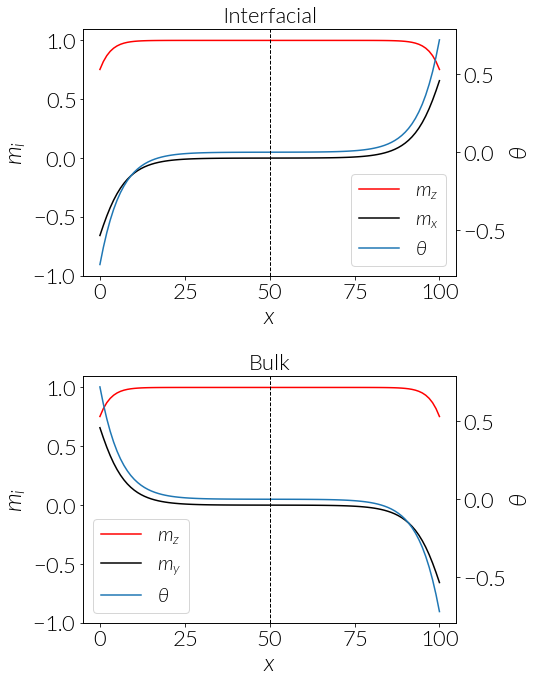

In [22]:
f = plt.figure(figsize=(8, 16/1.6))

# -----------------------------------------------------------------------------

ax = f.add_subplot(211)

p1 = plt.plot(r_array, np.cos(solution_int[:, 0]), 'r', label=r'$m_z$')
p2 = plt.plot(r_array, np.sin(solution_int[:, 0]), 'k', label=r'$m_x$')
plt.ylim([-1, 1.1])
ax = plt.gca()

ax2 = plt.gca().twinx()
p3 = plt.plot(r_array, solution_int[:, 0], label=r"$\theta$")

lns = p1 + p2 + p3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=4)

plt.axvline(x=l/2, ls='--', lw=1, color='k')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$m_{i}$')
ax2.set_ylabel(r"$\theta$")

plt.title('Interfacial', fontweight='light')

# -----------------------------------------------------------------------------

ax = f.add_subplot(212)

p1 = plt.plot(r_array, np.cos(solution_bulk[:, 0]), 'r', label=r'$m_z$')
p2 = plt.plot(r_array, np.sin(solution_bulk[:, 0]), 'k', label=r'$m_y$')
plt.ylim([-1, 1.1])
ax = plt.gca()

ax2 = plt.gca().twinx()
p3 = plt.plot(r_array, solution_bulk[:, 0], label=r"$\theta$")

lns = p1 + p2 + p3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=3)

plt.axvline(x=l/2, ls='--', lw=1, color='k')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$m_{i}$')
ax2.set_ylabel(r"$\theta$")

plt.title('Bulk', fontweight='light')

# -----------------------------------------------------------------------------
plt.tight_layout()
plt.show()

# Comparison with simulations

Here we compare the semi-analytical result with the simulations data:

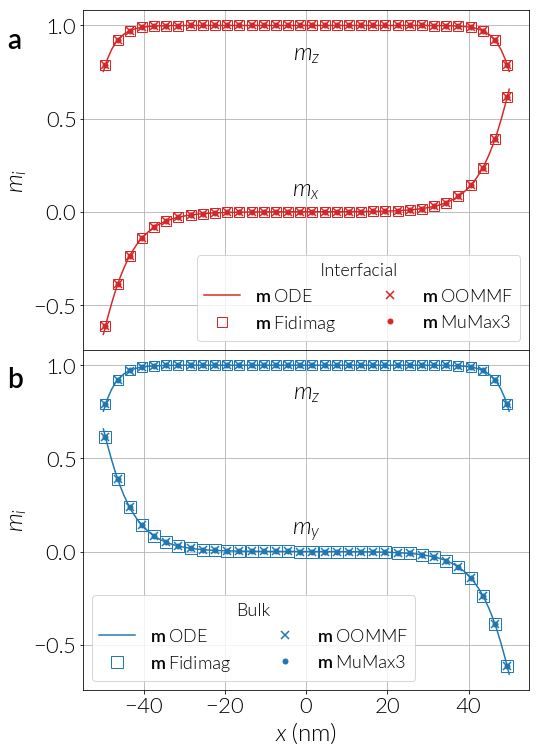

In [23]:
f, axs = plt.subplots(nrows=2, sharex=True, figsize=(8, 20/1.6))

# ODE solve:
axs[0].plot(r_array - l / 2, np.sin(solution_int[:, 0]), 'C3-', label=r'$\mathbf{m}$ ODE')
axs[0].plot(r_array - l / 2, np.cos(solution_int[:, 0]), 'C3-')

# Fidimag interfacial DMI
axs[0].plot(r_fidimag[:, 0][::3] - l / 2, m_fidimag[0][0][::3], 'C3s', label=r'$\mathbf{m}$ Fidimag', 
         markerfacecolor='None', ms=10)
axs[0].plot(r_fidimag[:, 0][::3] - l / 2, m_fidimag[0][2][::3], 'C3s', 
         markerfacecolor='None', ms=10)

# OOMMF interfacial DMI
axs[0].plot(x_oommf[::3] / nm, m_oommf[0][0][::3], 'C3x', label=r'$\mathbf{m}$ OOMMF', mew=1.5, ms=8)
axs[0].plot(x_oommf[::3] / nm, m_oommf[0][2][::3], 'C3x', mew=1.5, ms=8)

# MuMax3 interfacial DMI
axs[0].plot(r_mumax[0][:, 0][::3] - l / 2, m_mumax[0][:, 0][::3], 'C3o', ms=5, label=r'$\mathbf{m}$ MuMax3')
axs[0].plot(r_mumax[0][:, 0][::3] - l / 2, m_mumax[0][:, 2][::3], 'C3o', ms=5)

leg = axs[0].legend(loc=0, ncol=2, fontsize=18)
leg.set_title('Interfacial', prop={'size':18})
axs[0].set_xlabel(r'$x$ (nm)')
axs[0].set_ylabel(r'$m_{i}$')
axs[0].grid()

axs[0].text(0.5, 0.9, r'$m_{z}$', horizontalalignment='center', verticalalignment='top', 
         transform=axs[0].transAxes)

axs[0].text(0.5, 0.5, r'$m_{x}$', horizontalalignment='center', verticalalignment='top', 
         transform=axs[0].transAxes)

axs[0].text(-0.17, 0.95, 'a', horizontalalignment='left', verticalalignment='top', 
         transform=axs[0].transAxes, fontweight='bold', fontsize=28)

# -----------------------------------------------------------------------------

# ODE solve:
axs[1].plot(r_array - l / 2, np.sin(solution_bulk[:, 0]), 'C0-', label=r'$\mathbf{m}$ ODE')
axs[1].plot(r_array - l / 2, np.cos(solution_bulk[:, 0]), 'C0-')

# Fidimag interfacial DMI
axs[1].plot(r_fidimag[:, 0][::3] - l / 2, m_fidimag[1][1][::3], 'C0s', label=r'$\mathbf{m}$ Fidimag', 
         markerfacecolor='None', ms=12)
axs[1].plot(r_fidimag[:, 0][::3] - l / 2, m_fidimag[1][2][::3], 'C0s', 
            markerfacecolor='None', ms=10)

# OOMMF bulk DMI
axs[1].plot(x_oommf[::3] / nm, m_oommf[1][1][::3], 'C0x', label=r'$\mathbf{m}$ OOMMF', mew=1.5, ms=8)
axs[1].plot(x_oommf[::3] / nm, m_oommf[1][2][::3], 'C0x', mew=1.5, ms=8)

# MuMax3 interfacial DMI
axs[1].plot(r_mumax[1][:, 0][::3] - l / 2, m_mumax[1][:, 1][::3], 'C0o', ms=5, label=r'$\mathbf{m}$ MuMax3')
axs[1].plot(r_mumax[1][:, 0][::3] - l / 2, m_mumax[1][:, 2][::3], 'C0o', ms=5)

leg = axs[1].legend(loc=0, ncol=2, fontsize=18)
leg.set_title('Bulk', prop={'size':18})
axs[1].set_xlabel(r'$x$ (nm)')
axs[1].set_ylabel(r'$m_{i}$')
axs[1].grid()

axs[1].text(0.5, 0.9, r'$m_{z}$', horizontalalignment='center', verticalalignment='top', 
         transform=axs[1].transAxes)
axs[1].text(0.5, 0.5, r'$m_{y}$', horizontalalignment='center', verticalalignment='top', 
         transform=axs[1].transAxes)

axs[1].text(-0.17, 0.95, 'b', horizontalalignment='left', verticalalignment='top', 
         transform=axs[1].transAxes, fontweight='bold', fontsize=28)

# -----------------------------------------------------------------------------

plt.subplots_adjust(hspace=0)
# plt.legend(ncol=2, loc='lower left', bbox_to_anchor=(0, 1.02, 1.0, 1),
#            mode='expand', borderaxespad=0.)

plt.savefig('result_1d.pdf', dpi=300, bbox_inches='tight')

Save the data from the figure:

In [24]:
!mkdir -p data/results_1d

In [25]:
# Interfacial
np.savetxt('data/results_1d/result_1d_x-mx_interfacial_ODE.txt', np.column_stack((r_array - l / 2, np.sin(solution_int[:, 0]))))
np.savetxt('data/results_1d/result_1d_x-mz_interfacial_ODE.txt', np.column_stack((r_array - l / 2, np.cos(solution_int[:, 0]))))

for i, dmi in enumerate(['interfacial', 'bulk', 'D2d']):
    if dmi == 'interfacial':
        m = 'mx'
    else:
        m = 'my'
    
    np.savetxt('data/results_1d/result_1d_x-{}_{}_fidimag.txt'.format(m, dmi), np.column_stack((r_fidimag[:, 0] - l / 2, m_fidimag[i][0])))
    np.savetxt('data/results_1d/result_1d_x-mz_{}_fidimag.txt'.format(dmi), np.column_stack((r_fidimag[:, 0] - l / 2, m_fidimag[i][2])))

    np.savetxt('data/results_1d/result_1d_x-{}_{}_oommf.txt'.format(m, dmi), np.column_stack((x_oommf / nm, m_oommf[i][0])))
    np.savetxt('data/results_1d/result_1d_x-mz_{}_oommf.txt'.format(dmi), np.column_stack((x_oommf / nm, m_oommf[i][2])))

    np.savetxt('data/results_1d/result_1d_x-{}_{}_mumax3.txt'.format(m, dmi), np.column_stack((r_mumax[i][:, 0] - l / 2, m_mumax[i][:, 0])))
    np.savetxt('data/results_1d/result_1d_x-mz_{}_mumax3.txt'.format(dmi), np.column_stack((r_mumax[i][:, 0] - l / 2, m_mumax[i][:, 2])))


# Comparison of MuMax3 data without PBCs

Comparison of interfacial DMI between Fidimag and MuMax3 without using PBCs in MuMax3.

In [26]:
r_mumax_raw = [None for i in range(3)]
m_mumax_raw = [None for i in range(3)]

for i, dmi in enumerate(['inter', 'bulk', 'D2d']):

    data_mumax_raw = pd.read_csv('../sims/MUMAX3/1D/one_dim_{}.ovf'.format(dmi), 
                             comment='#', header=None, delim_whitespace=True)
    data_mumax_raw = data_mumax_raw.as_matrix()
    data_mumax_raw[:, :3] *= 1e9
    
    r_mumax_raw[i] = data_mumax_raw[:, :3]
    m_mumax_raw[i] = data_mumax_raw[:, 3:]

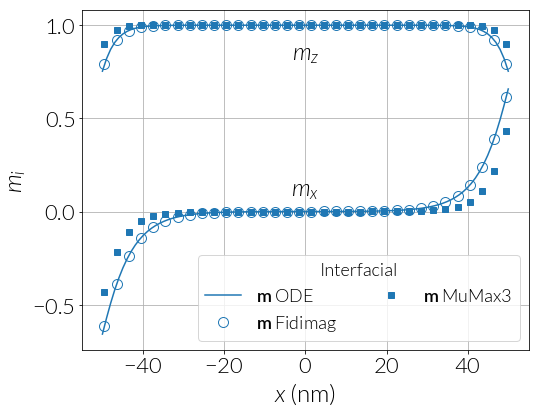

In [27]:
f, ax = plt.subplots(nrows=1, figsize=(8, 10/1.6))

# ODE solve:
ax.plot(r_array - l / 2, np.sin(solution_int[:, 0]), 'C0-', label=r'$\mathbf{m}$ ODE')
ax.plot(r_array - l / 2, np.cos(solution_int[:, 0]), 'C0-')

ax.plot(r_fidimag[:, 0][::3] - l / 2, m_fidimag[0][0][::3], 'C0o', label=r'$\mathbf{m}$ Fidimag', 
         markerfacecolor='None', ms=10)
ax.plot(r_fidimag[:, 0][::3] - l / 2, m_fidimag[0][2][::3], 'C0o', 
         markerfacecolor='None', ms=10)

ax.plot(r_mumax_raw[0][:, 0][::3] - l / 2, m_mumax_raw[0][:, 0][::3], 'sC0', label=r'$\mathbf{m}$ MuMax3')
ax.plot(r_mumax_raw[0][:, 0][::3] - l / 2, m_mumax_raw[0][:, 2][::3], 'sC0')

ax.legend()

leg = ax.legend(loc=0, ncol=2, fontsize=18)
leg.set_title('Interfacial', prop={'size':18})
ax.set_xlabel(r'$x$ (nm)')
ax.set_ylabel(r'$m_{i}$')
ax.grid()

ax.text(0.5, 0.9, r'$m_{z}$', horizontalalignment='center', verticalalignment='top', 
        transform=ax.transAxes)

ax.text(0.5, 0.5, r'$m_{x}$', horizontalalignment='center', verticalalignment='top', 
        transform=ax.transAxes)

plt.savefig('result_1d_mumax-no-pbc.pdf', bbox_inches='tight')